<a href="https://colab.research.google.com/github/dpb24/customer-segmentation/blob/main/Customer_Segmentation_for_XYZ_Entertainment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Targeting Weekday Growth: RFM-based Customer Segmentation for XYZ Entertainment


---


This notebook presents an analysis of customer-level booking data for the fictional hospitality client XYZ Entertainment Center, covering the period 1 January 2024 to 1 January 2025. The goal is to identify individuals most likely to respond to targeted promotions aimed at increasing bookings on Monday, Wednesday, and Thursday.

Building on the success of XYZ's current Tuesday campaign, we aim to extend weekday performance by targeting high-value, recently active customers who demonstrate untapped potential for engagement on these additional weekdays.

To achieve this, we apply Recency, Frequency, Monetary (RFM) analysis in conjunction with K-means clustering to: segment the customer base; quantify weekday-specific engagement; identify strategic targets for a data-driven marketing campaign.

> Note: The original dataset used for this analysis is proprietary and not included. However, all code and methodology are retained to demonstrate the analytical approach.

## 1 Imports
We import relevant Python packages for data manipulation and visualisation.

In [1]:
# Operational packages
import pandas as pd
import numpy as np
import warnings
import math
from datetime import datetime
from google.colab import files
import re
import time

# Visualisation packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Statistical packages
from sklearn.metrics import silhouette_score

# Modelling packages
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore", category=FutureWarning)

## 2 Data Overview



### 2.1 Data Description
The dataset contains anonymised, customer-level booking data for XYZ Entertainment Center for the period between 01-01-2024 and 01-01-2025

The objective is as follows:

> "Our hospitality client are looking to drive an increased number of weekday bookings, with a focus on Monday, Wednesday and Thursday (at present Tuesday's perform quite well as there is a 50% promotion that day). Using the attached booking data, we'd like you to identify the individuals you think are best candidates to target for weekday booking."

### 2.2 Data Dictionary


| Column Name       | Data Type | Description                                    | Example Values                                      |
|-------------------|-----------|------------------------------------------------|-----------------------------------------------------|
| BOOKINGSITENAME   | object    | Name of Sites                                  | Southampton, Manchester (Parrswood), Walsall        |
| BOOKINGDATE       | object    | Date of Booking                                | 2024-05-27, 2024-11-02, 2024-02-22                  |
| BOWLINGPARTYSIZE  | float64   | Covers: Number of people in the party          | 5.0, 4.0, 2.0                                       |
| BOWLINGQTY        | float64   | Quantity of games booked                       | 3.0, 2.0, 1.0                                       |
| VISITDATE         | object    | Visit Date                                     | 2024-05-27, 2024-11-02, 2024-02-25                  |
| BOOKINGCHANNEL    | object    | Booking Channel                                | Made from Web, Contact Centre, Made from Local      |
| BOOKINGVALUE      | float64   | Amount spent on booking                        | 14.5, 114.5, 50.4                                   |
| RSRVTYPEKEY       | int64     | Numeric indicator for reservation type         | 841, 825, 828                                       |
| RSRVTYPEDESC      | object    | Reservation Description                        | Web Pingo's, Web Bowl Other, Web Eat N Play         |
| EMAIL             | object    | Customer Email (anonymised)                    | EMAIL_d36e1d1e, EMAIL_7f5c9e41, EMAIL_b3a9bca7      |

## 3 Data Loading & Initial Checks

We load the hospitality booking datasets into a pandas DataFrame, assigning the variable **bookingdata_df**.

In [2]:
# Upload CSV file
uploaded = files.upload()

Saving Booking_data.csv to Booking_data.csv


In [4]:
# Import dataset from CSV file
bookingdata_df = pd.read_csv('Booking_data.csv')

In [5]:
# Display first 5 rows of booking data
bookingdata_df.head(5)

BOOKINGSITENAME BOOKINGDATE  BOWLINGPARTYSIZE  BOWLINGQTY  \
0             Southampton  27/05/2024               NaN         NaN   
1  Manchester (Parrswood)  02/11/2024               5.0         3.0   
2                 Walsall  22/02/2024               4.0         2.0   
3                 Walsall  08/03/2024               2.0         2.0   
4              Chichester  04/08/2024               5.0         2.0   

    VISITDATE BOOKINGCHANNEL  BOOKINGVALUE  RSRVTYPEKEY    RSRVTYPEDESC  \
0  27/05/2024  Made from Web          14.5          841     Web Pingo's   
1  02/11/2024  Made from Web         114.5          825  Web Bowl Other   
2  25/02/2024  Made from Web          50.4          825  Web Bowl Other   
3  08/03/2024  Made from Web          26.0          825  Web Bowl Other   
4  04/08/2024  Made from Web          97.6          828  Web Eat N Play   

            EMAIL  
0  EMAIL_d36e1d1e  
1  EMAIL_7f5c9e41  
2  EMAIL_b3a9bca7  
3  EMAIL_b3a9bca7  
4  EMAIL_cf345354

In [6]:
# Check basic info of the booking data
bookingdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550491 entries, 0 to 550490
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BOOKINGSITENAME   550491 non-null  object 
 1   BOOKINGDATE       550491 non-null  object 
 2   BOWLINGPARTYSIZE  517092 non-null  float64
 3   BOWLINGQTY        487788 non-null  float64
 4   VISITDATE         550491 non-null  object 
 5   BOOKINGCHANNEL    550491 non-null  object 
 6   BOOKINGVALUE      550482 non-null  float64
 7   RSRVTYPEKEY       550491 non-null  int64  
 8   RSRVTYPEDESC      542690 non-null  object 
 9   EMAIL             550491 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 42.0+ MB


In [7]:
# Get descriptive stats of the booking data
bookingdata_df.describe()

BOWLINGPARTYSIZE     BOWLINGQTY   BOOKINGVALUE    RSRVTYPEKEY
count     517092.000000  487788.000000  550482.000000  550491.000000
mean           4.040842       1.977496      38.367524     808.076027
std            2.919991       1.058890      34.542300      68.369186
min            0.000000       1.000000       0.000000       4.000000
25%            2.000000       1.000000      20.000000     825.000000
50%            3.000000       2.000000      30.000000     825.000000
75%            5.000000       2.000000      44.590000     827.000000
max          227.000000      48.000000    1577.600000     931.000000

In [8]:
# Check size of the dataset
bookingdata_df.shape

(550491, 10)

In [9]:
# Check number of unique values
bookingdata_df.nunique()

BOOKINGSITENAME         54
BOOKINGDATE            476
BOWLINGPARTYSIZE       100
BOWLINGQTY              35
VISITDATE              366
BOOKINGCHANNEL           3
BOOKINGVALUE         12982
RSRVTYPEKEY             56
RSRVTYPEDESC            46
EMAIL               335328
dtype: int64

In [10]:
# Compute and summarize bowling site performance metrics
bowlingsite_counts = bookingdata_df['BOOKINGSITENAME'].value_counts()
bowlingsite_percent = bookingdata_df['BOOKINGSITENAME'].value_counts(normalize=True) * 100

bowlingsites_df = pd.DataFrame({
    'BOWLINGSITE': bowlingsite_counts.index,
    'COUNT': bowlingsite_counts.values,
    'PERCBOOKINGS': bowlingsite_percent.values.round(2)
})

In [11]:
# Geocode bowling site names and convert to GeoDataFrame for UK map plot
site_names = bowlingsites_df['BOWLINGSITE']
geolocator = Nominatim(user_agent="bowling_mapper", timeout=5)

locations = []

for name in site_names:
    try:
        location = geolocator.geocode(f"{name}, UK")
        if location:
            locations.append({'Site': name, 'Latitude': location.latitude, 'Longitude': location.longitude})
        else:
            locations.append({'Site': name, 'Latitude': None, 'Longitude': None})
    except (GeocoderTimedOut, GeocoderUnavailable):
        print(f"Geocoding failed for {name}. Assigning placeholder coordinates.")
        locations.append({'Site': name, 'Latitude': None, 'Longitude': None})

    time.sleep(1)

sites_df = pd.DataFrame(locations)

sites_gdf = gpd.GeoDataFrame(
    sites_df,
    geometry=gpd.points_from_xy(sites_df['Longitude'], sites_df['Latitude']),
    crs="EPSG:4326"
)

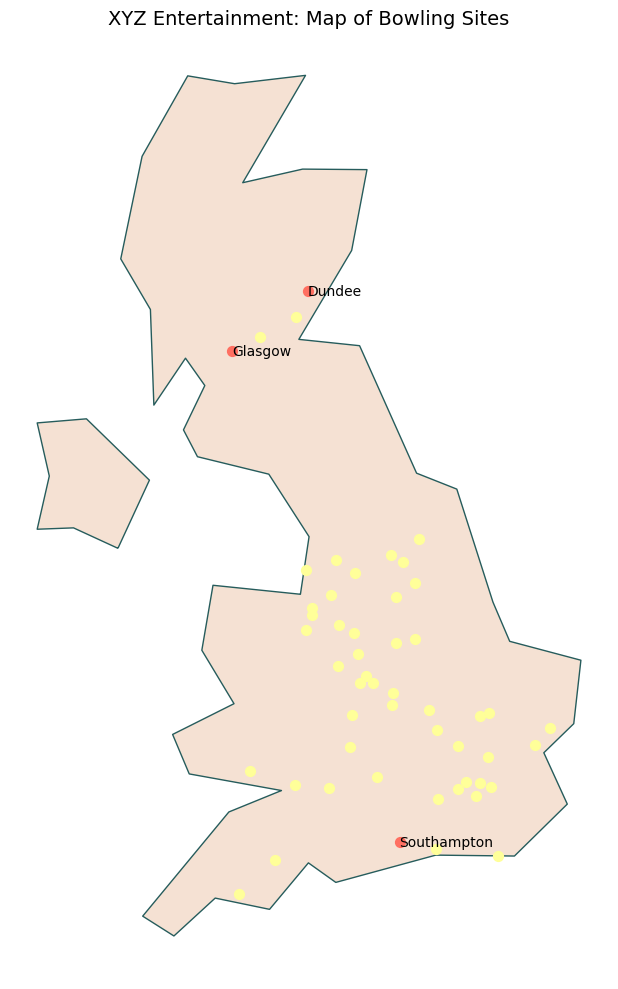

BOOKINGSITENAME
Dundee         4.837318
Glasgow        4.321052
Southampton    3.895250
Warrington     2.842372
Castleford     2.680516
Name: proportion, dtype: float64

In [12]:
# Plot map of bowling sites
highlight_sites = ['Dundee', 'Glasgow', 'Southampton']
highlight_gdf = sites_gdf[sites_gdf['Site'].isin(highlight_sites)]
other_gdf = sites_gdf[~sites_gdf['Site'].isin(highlight_sites)]

fig, ax = plt.subplots(figsize=(8, 10))


world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")
uk = world[world['ADMIN'] == 'United Kingdom']
uk.plot(ax=ax, color='#F5E1D3', edgecolor='#265C5C')

other_gdf.plot(ax=ax, color='#FFFF99', markersize=50)
highlight_gdf.plot(ax=ax, color='#FF6F61', markersize=50)

for x, y, label in zip(highlight_gdf.geometry.x, highlight_gdf.geometry.y, highlight_gdf['Site']):
    ax.text(x, y, label, fontsize=10, ha='left', va='center')

plt.title('XYZ Entertainment: Map of Bowling Sites', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('uk_bowling_sites.png', dpi=300, transparent=True)
plt.show()

bowlingsite_percent.head(5)

In [13]:
# Examine booking channel frequencies
channel_counts = bookingdata_df['BOOKINGCHANNEL'].value_counts()
channel_percent = bookingdata_df['BOOKINGCHANNEL'].value_counts(normalize=True) * 100

booking_channels_df = pd.DataFrame({
    'BOOKINGCHANNEL': channel_counts.index,
    'COUNT': channel_counts.values,
    'PERCBOOKINGS': channel_percent.values.round(2)
})

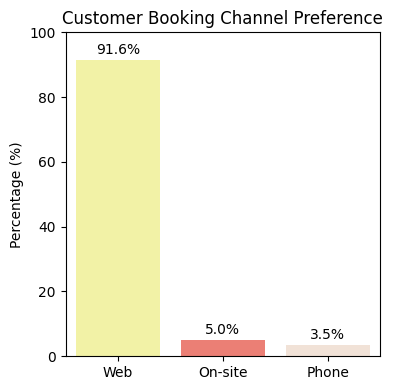

BOOKINGCHANNEL   COUNT  PERCBOOKINGS BOOKINGCHANNEL_DISPLAY
0    Made from Web  504046         91.56                    Web
1  Made from Local   27322          4.96                On-site
2   Contact Centre   19123          3.47                  Phone

In [14]:
# Plot Booking Channel Percentages
label_map = {
    'Made from Web': 'Web',
    'Made from Local': 'On-site',
    'Contact Centre': 'Phone',
}
booking_channels_df['BOOKINGCHANNEL_DISPLAY'] = booking_channels_df['BOOKINGCHANNEL'].map(label_map)
plt.figure(figsize=(4, 4))
ax = sns.barplot(
    x='BOOKINGCHANNEL_DISPLAY',
    y='PERCBOOKINGS',
    data=booking_channels_df,
    palette=['#FFFF99', '#FF6F61', '#F5E1D3']
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10, padding=2)

plt.title('Customer Booking Channel Preference')
plt.ylabel('Percentage (%)')
plt.xlabel('')
plt.ylim(0,100)
plt.tight_layout()
plt.savefig('bookingchannel.png', dpi=300, transparent=True)
plt.show()

booking_channels_df

In [15]:
# Download plots
files.download('bookingchannel.png')
files.download('uk_bowling_sites.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The dataset **bookingdata_df** contains **550,491** rows across **10** columns, capturing customer booking activity across **54** bowling sites in the UK.

Assuming each customer is uniquely identified by their email address, this corresponds to **335,328** customers and **550,491** total bookings.

The top performing sites by booking share are: Dundee (**4.8%**); Glasgow (**4.3%**); Southampton (**3.9%**).

Customers book through three main channels: internet (**91.6%**); in-person at a bowling site (**5.0%**); telephone via the Contact Centre (**3.5%**).

Initial inspection reveals **46** distinct reservation descriptions. However, discrepancies between text labels and their associated numeric indicators suggest potential data quality issues, which may warrant cleansing before downstream analysis.

## 4 Data Cleaning

We check for missing values.

In [16]:
# Check for missing values
bookingdata_df.isna().sum()

BOOKINGSITENAME         0
BOOKINGDATE             0
BOWLINGPARTYSIZE    33399
BOWLINGQTY          62703
VISITDATE               0
BOOKINGCHANNEL          0
BOOKINGVALUE            9
RSRVTYPEKEY             0
RSRVTYPEDESC         7801
EMAIL                   0
dtype: int64

In [17]:
# Drop rows with missing values
subset_bookingdata_df = bookingdata_df.dropna()

# check size of subset of dataset
subset_bookingdata_df.shape

(482216, 10)

We check for duplicate entries and remove if necessary. In the absence of booking time information, we assume that identical records for advance bookings (ie., where `BOOKINGDATE` differs from `VISITDATE`) represent true duplicates. In contrast, repeated bookings made on the visit date are retained, as we interpret these as genuine multiple bookings. A unique `BOOKINGREFERENCE` is added to each record to serve as a primary identifier.

In [18]:
# Check for all duplicate rows
subset_bookingdata_df.duplicated().sum()

np.int64(8009)

In [19]:
# Check for duplicate rows for bookings made in advance
subset_bookingdata_df[subset_bookingdata_df['BOOKINGDATE'] != subset_bookingdata_df['VISITDATE']].duplicated().sum()

np.int64(667)

In [20]:
# Remove duplicate entries for advance bookings
advance_bookings = subset_bookingdata_df[subset_bookingdata_df['BOOKINGDATE'] != subset_bookingdata_df['VISITDATE']]
advance_bookings = advance_bookings.drop_duplicates()

In [21]:
# Preserve duplicate entries for same-day bookings
sameday_bookings = subset_bookingdata_df[subset_bookingdata_df['BOOKINGDATE'] == subset_bookingdata_df['VISITDATE']]

In [22]:
# Combine cleaned advance bookings and all same-day bookings
subset2_bookingdata_df = pd.concat([advance_bookings, sameday_bookings], ignore_index=True)

# Reset index
subset2_bookingdata_df.reset_index(drop=True, inplace=True)

In [23]:
# Add unique booking reference
subset2_bookingdata_df['BOOKINGREF'] = 'BR' + subset2_bookingdata_df.index.astype(str).str.zfill(7)

We check the data types of the columns.

In [24]:
# Check data types of columns
subset2_bookingdata_df.dtypes

BOOKINGSITENAME      object
BOOKINGDATE          object
BOWLINGPARTYSIZE    float64
BOWLINGQTY          float64
VISITDATE            object
BOOKINGCHANNEL       object
BOOKINGVALUE        float64
RSRVTYPEKEY           int64
RSRVTYPEDESC         object
EMAIL                object
BOOKINGREF           object
dtype: object

We convert `BOWLINGPARTYSIZE` and `BOWLINGQTY` from *float64* to *int64* to reflect their nature as discrete, whole-number values.

In [25]:
# Create a deep copy of the DataFrame
subset3_bookingdata_df = subset2_bookingdata_df.copy()

# Convert columns from float64 to int64
cols = ['BOWLINGPARTYSIZE', 'BOWLINGQTY']
subset3_bookingdata_df[cols] = subset3_bookingdata_df[cols].astype('int64')

We convert `BOOKINGDATE` and `VISITDATE`, currently stored as strings in DD/MM/YYYY format, to pandas *datetime64* data type to facilitate time-based filtering and analysis.

In [26]:
# Check dates are in format DD/MM/YYYY
date_pattern = r'^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[0-2])/\d{4}$'

bookingdate_formats = subset3_bookingdata_df['BOOKINGDATE'].astype(str).str.match(date_pattern)
print(f"BOOKINGDATE valid format count: {bookingdate_formats.sum()} / {len(bookingdate_formats)}")

visitdate_formats = subset3_bookingdata_df['VISITDATE'].astype(str).str.match(date_pattern)
print(f"VISITDATE valid format count: {visitdate_formats.sum()} / {len(visitdate_formats)}")

BOOKINGDATE valid format count: 481549 / 481549
VISITDATE valid format count: 481549 / 481549


In [27]:
# Convert columns to datetime
subset3_bookingdata_df['BOOKINGDATE']  = pd.to_datetime(subset3_bookingdata_df['BOOKINGDATE'], format='%d/%m/%Y', errors='coerce')
subset3_bookingdata_df['VISITDATE']  = pd.to_datetime(subset3_bookingdata_df['VISITDATE'], format='%d/%m/%Y', errors='coerce')

We exclude bookings where `BOWLINGPARTYSIZE` is zero.

In [28]:
# Filter out bookings with zero players
subset4_bookingdata_df = subset3_bookingdata_df[subset3_bookingdata_df['BOWLINGPARTYSIZE'] != 0]

We exclude bookings made outside the dataset's timeframe (1 January 2024 to 1 January 2025).

In [29]:
# Filter out bookings made outside timeframe
subset5_bookingdata_df = subset4_bookingdata_df[
    (subset4_bookingdata_df['BOOKINGDATE'] >= '2024-01-01') &
    (subset4_bookingdata_df['BOOKINGDATE'] < '2025-01-01')].copy()

We create a `CUSTOMERID` to uniquely identify each customer, based on their email address.

In [30]:
# Create a unique customer ID
subset5_bookingdata_df['CUSTOMERID'] = subset5_bookingdata_df['EMAIL'].astype('category').cat.codes

In [31]:
# Create copy of cleaned dataframe
cleaned_bookingdata_df=subset5_bookingdata_df.copy()

## 5 Exploratory Data Analysis

### 5.1 Weekday Booking Overview

We examine booking behaviour across weekdays, highlighting Tuesday’s strong performance—currently supported by a 50% promotion—and identifying opportunities to increase footfall on Monday, Wednesday, and Thursday through targeted customer segmentation.

In [32]:
# Create new variables
cleaned_bookingdata_df['VISITDAY'] = cleaned_bookingdata_df['VISITDATE'].dt.day_name()
cleaned_bookingdata_df['BOOKINGVALUEPERPERSON'] = cleaned_bookingdata_df['BOOKINGVALUE'] / cleaned_bookingdata_df['BOWLINGPARTYSIZE']
cleaned_bookingdata_df['BOOKINGVALUEPERGAME'] = cleaned_bookingdata_df['BOOKINGVALUE'] / cleaned_bookingdata_df['BOWLINGQTY']
cleaned_bookingdata_df['BOOKINGVALUEPERPERSONPERGAME'] = cleaned_bookingdata_df['BOOKINGVALUE'] / (cleaned_bookingdata_df['BOWLINGQTY'] * cleaned_bookingdata_df['BOWLINGPARTYSIZE'])

In [33]:
# Group by VISITDAY with multiple aggregation functions
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_data_df = cleaned_bookingdata_df.groupby('VISITDAY').agg(
    BookingsCount=('VISITDAY', 'count'),
    FootfallCount=('BOWLINGPARTYSIZE', 'sum'),
    TotalRevenue=('BOOKINGVALUE', 'sum'),
    Avg_BOWLINGPARTYSIZE=('BOWLINGPARTYSIZE', 'mean'),
    Avg_BOWLINGQTY=('BOWLINGQTY', 'mean'),
    Avg_BOOKINGVALUE=('BOOKINGVALUE', 'mean'),
    Avg_BOOKINGVALUEPERPERSON=('BOOKINGVALUEPERPERSON', 'mean'),
    Avg_BOOKINGVALUEPERGAME=('BOOKINGVALUEPERGAME', 'mean'),
    Avg_BOOKINGVALUEPERPERSONPERGAME=('BOOKINGVALUEPERPERSONPERGAME', 'mean')
).reset_index()

# Calculate percentage columns
weekday_data_df['PercBookings'] = (
    100 * weekday_data_df['BookingsCount'] / weekday_data_df['BookingsCount'].sum()
)
weekday_data_df['PercRevenue'] = (
    100 * weekday_data_df['TotalRevenue'] / weekday_data_df['TotalRevenue'].sum()
)

weekday_data_df['VISITDAY'] = pd.Categorical(weekday_data_df['VISITDAY'], categories=weekday_order, ordered=True)
weekday_data_df = weekday_data_df.sort_values('VISITDAY').reset_index(drop=True)


In [34]:
# Define function to plot barchart by weekday
def PlotWeekdayBarChart(var, ylabel, title, filename):
  """
  Plot barchart for a variable by weekday.

  Parameters:
  - var: str, the name of the variable to plot
  """
  plt.figure(figsize=(10, 4))
  highlight_days = ['Monday', 'Wednesday', 'Thursday']
  colors = ['#FFFF99' if x in highlight_days else '#FF6F61' for x in weekday_data_df['VISITDAY']]
  sns.barplot(
      x='VISITDAY',
      y=var,
      data=weekday_data_df,
      palette=colors
      )
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel('')
  plt.savefig(filename, dpi=300, transparent=True)
  plt.show()

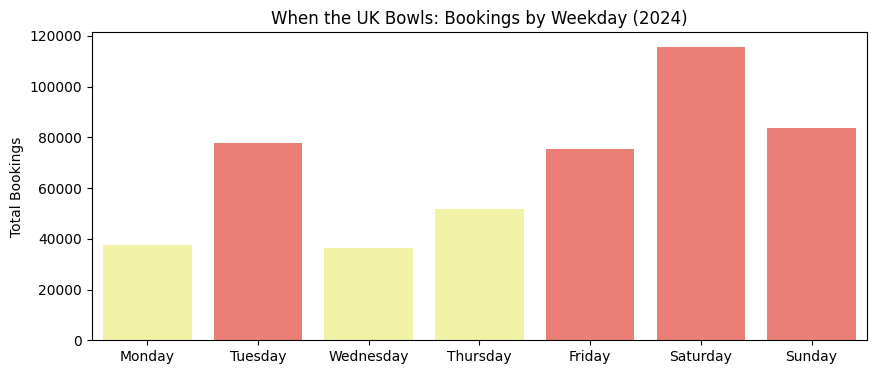

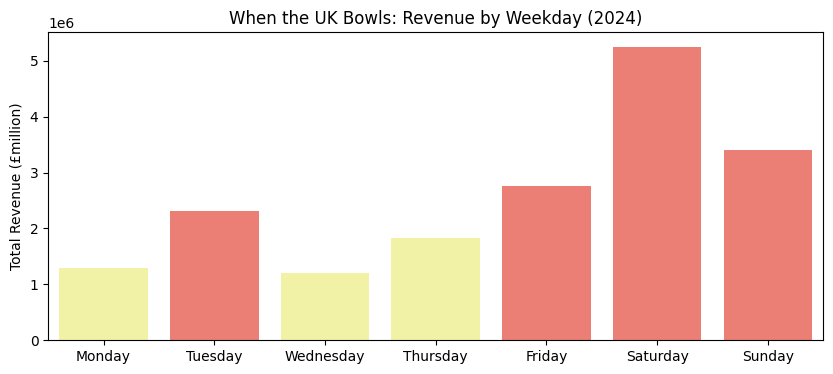

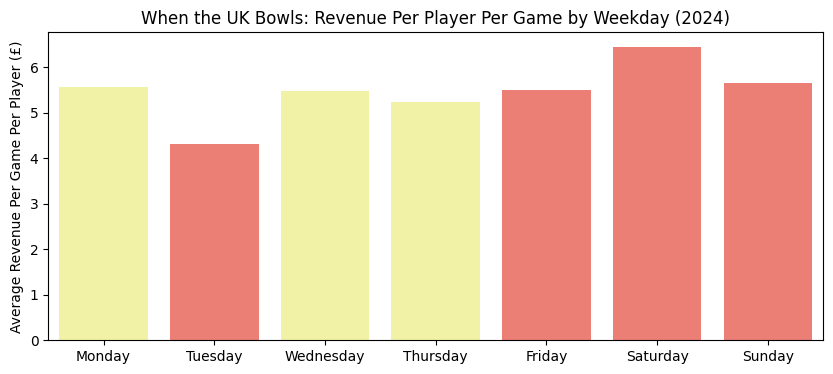

VISITDAY  BookingsCount  FootfallCount  TotalRevenue  \
0     Monday          37390         139237    1284892.11   
1    Tuesday          77879         310505    2317246.76   
2  Wednesday          36245         132535    1209917.49   
3   Thursday          51750         195779    1821117.96   
4     Friday          75227         291417    2759334.34   
5   Saturday         115587         477313    5245093.22   
6     Sunday          83617         334513    3407774.95   

   Avg_BOWLINGPARTYSIZE  Avg_BOWLINGQTY  Avg_BOOKINGVALUE  \
0              3.723910        1.856887         34.364592   
1              3.987018        1.975988         29.754449   
2              3.656642        1.869968         33.381639   
3              3.783169        1.976792         35.190685   
4              3.873835        1.929680         36.680106   
5              4.129470        1.896122         45.377882   
6              4.000538        2.076193         40.754571   

   Avg_BOOKINGVALUEPERPERSON  Avg_BOOKINGVALUEPERGAME  \
0                   9.436773                19.087663   
1                   7.707223                15.520109   
2                   9.365592                18.304940   
3                   9.420998                17.914547   
4                   9.736428                19.315833   
5                  11.220536                24.312183   
6                  10.293934                21.042260   

   Avg_BOOKINGVALUEPERPERSONPERGAME  PercBookings  PercRevenue  
0                          5.561442      7.827170     7.120340  
1                          4.309633     16.303080    12.841221  
2                          5.483153      7.587477     6.704861  
3                          5.230323     10.833272    10.091881  
4                          5.489328     15.747914    15.291087  
5                          6.446175     24.196820    29.066133  
6                          5.648683     17.504265    18.884477

In [35]:
# Plot barcharts showing bookings and revenue by weekday
PlotWeekdayBarChart('BookingsCount', 'Total Bookings', 'When the UK Bowls: Bookings by Weekday (2024)', 'weekday_totalbookings.png')
PlotWeekdayBarChart('TotalRevenue', 'Total Revenue (£million)', 'When the UK Bowls: Revenue by Weekday (2024)', 'weekday_totalrevenues.png')
PlotWeekdayBarChart('Avg_BOOKINGVALUEPERPERSONPERGAME', 'Average Revenue Per Game Per Player (£)', 'When the UK Bowls: Revenue Per Player Per Game by Weekday (2024)', 'weekday_revenueperplayerpergame.png')

weekday_data_df

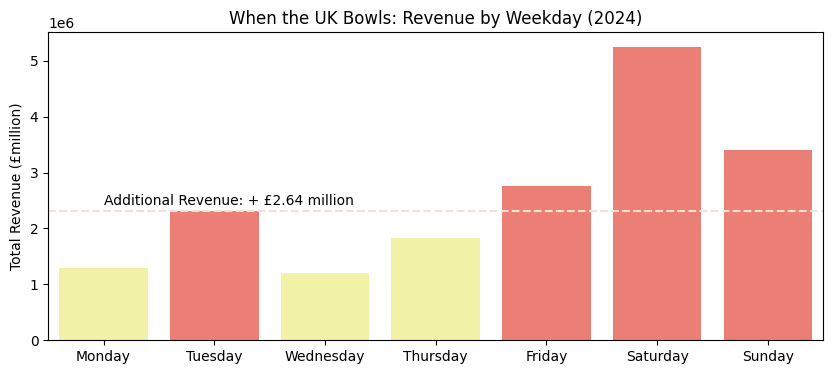

In [36]:
# Plot barchart by weekday with annotation
plt.figure(figsize=(10, 4))

highlight_days = ['Monday', 'Wednesday', 'Thursday']
colors = ['#FFFF99' if x in highlight_days else '#FF6F61' for x in weekday_data_df['VISITDAY']]
ax = sns.barplot(
    x='VISITDAY',
    y='TotalRevenue',
    data=weekday_data_df,
    palette=colors
    )

ax.axhline(
    y=2317246.76,
    color='#F5E1D3',
    linestyle='--',
    linewidth=1.5
    )

ax.text(
    x=0,
    y=2317246.76 + (0.02 * 2317246.76),  # just above the line
    s='Additional Revenue: + £2.64 million',
    ha='left',
    va='bottom',
    fontsize=10,
)

ax.set_title('When the UK Bowls: Revenue by Weekday (2024)')
ax.set_ylabel('Total Revenue (£million)')
ax.set_xlabel('')

plt.savefig('weekday_totalrevenues-annotated.png', dpi=300, transparent=True)
plt.show()

In [37]:
# Download plots
files.download('weekday_totalbookings.png')
files.download('weekday_totalrevenues.png')
files.download('weekday_revenueperplayerpergame.png')
files.download('weekday_totalrevenues-annotated.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The data shows that Tuesday consistently outperforms other non-weekend days in both bookings and revenue, indicating that the existing 50% promotion is driving strong engagement. A new campaign targeting Monday, Wednesday, and Thursday should be designed to run in parallel — leveraging proven tactics while expanding midweek reach.

* Although Tuesday shows a lower average revenue per player per game (**£4.30**) compared to Monday (**£5.55**), it delivers significantly higher total revenue — **£2.34 million** across UK sites versus **£1.31 million** on Monday.

* Saturday remains dominant in both volume and value, accounting for **24.13%** of total weekly bookings and generating **£5.31 million** in revenue — more than Monday, Wednesday, and Thursday combined.

* If Monday, Wednesday, and Thursday matched Tuesday's turnover, it would generate an additional **£2.64 million** in revenue.

### 5.2 RFM Analysis

We apply Recency, Frequency, and Monetary (RFM) analysis to quantify customer engagement and value. These metrics allow us to differentiate between active, high-spend individuals and lapsed or low-frequency bookers.

We create three new features:

* `Recency`: The number of days since the customer's most recent booking, measured relative to the latest booking date in the dataset.
* `Frequency`: The total number of bookings made by the customer.
* `Monetary`: The total amount spent by the customer across all bookings.

In [38]:
# Aggregate data by customer
def most_common(series):
    return series.value_counts().idxmax()

customer_data_df = cleaned_bookingdata_df.groupby('CUSTOMERID').agg(
    Tot_BOOKINGS=('BOOKINGREF', 'count'),
    HOMESITENAME=('BOOKINGSITENAME', most_common),
    Last_BOOKINGDATE=('BOOKINGDATE', 'max'),
    Avg_BOWLINGPARTYSIZE=('BOWLINGPARTYSIZE', 'mean'),
    Avg_BOWLINGQTY=('BOWLINGQTY', 'mean'),
    Last_VISITDATE=('VISITDATE', 'max'),
    Avg_VISITDAY=('VISITDAY', most_common),
    Avg_BOOKINGCHANNEL=('BOOKINGCHANNEL', most_common),
    Avg_BOOKINGVALUE=('BOOKINGVALUE', 'mean'),
    Tot_BOOKINGVALUE=('BOOKINGVALUE', 'sum'),
    Avg_RSRVTYPEKEY=('RSRVTYPEKEY', most_common),
    Avg_RSRVTYPEDESC=('RSRVTYPEDESC', most_common),
    EMAIL=('EMAIL', 'first')
    ).reset_index()

In [39]:
# Calculate RFM Scores
reference_date = cleaned_bookingdata_df['BOOKINGDATE'].max()
customer_data_df['RECENCY'] = (reference_date - customer_data_df['Last_BOOKINGDATE']).dt.days
customer_data_df['FREQUENCY'] = customer_data_df['Tot_BOOKINGS']
customer_data_df['MONETARY'] = customer_data_df['Tot_BOOKINGVALUE']

In [40]:
# Summary statistics for RFM metrics
customer_data_df[['RECENCY', 'FREQUENCY', 'MONETARY']].describe()

RECENCY      FREQUENCY       MONETARY
count  303905.000000  303905.000000  303905.000000
mean      170.858360       1.571856      59.378348
std       109.708835      24.355659     556.692212
min         0.000000       1.000000       0.000000
25%        72.000000       1.000000      26.000000
50%       154.000000       1.000000      41.780000
75%       272.000000       2.000000      69.550000
max       365.000000   13402.000000  304829.480000

We observe the presence of extreme outliers in the dataset—for example, a booking value of **£304,829**, compared to a median of **£41.78**, and a customer with **13,402** bookings, versus a median of **1**.

## 6 Customer Segmentation

We construct a K-means clustering model — a partitioning algorithm that groups observations into *k* distinct clusters by minimising variance within each cluster — to segment customers based on the `RECENCY`, `FREQUENCY`, and `MONETARY` features.

### 6.1 Feature Preparation

We exclude extreme outliers and scale each feature so they have equal influence on the clustering model.

In [41]:
# Select features
rfm_features = customer_data_df[['RECENCY', 'FREQUENCY', 'MONETARY']].copy()

In [42]:
# Cap metrics at 99th percentile
for col in ['FREQUENCY', 'MONETARY']:
    upper_limit = rfm_features[col].quantile(0.99)
    rfm_features[col] = rfm_features[col].clip(upper=upper_limit)

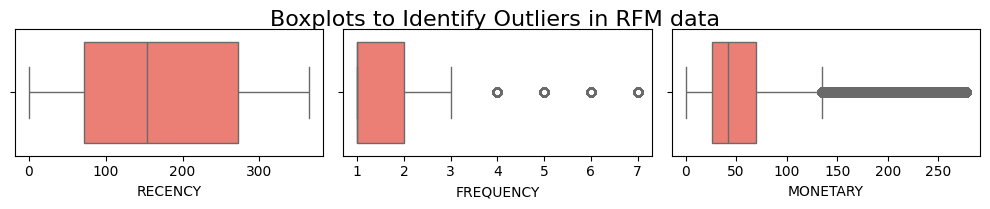

In [43]:
# Create boxplots of RFM metrics
plt.figure(figsize=(10, 2))
plt.subplot(1, 3, 1)
sns.boxplot(x = 'RECENCY', data = rfm_features, color='#FF6F61')
plt.title('')
plt.xlabel('RECENCY')
plt.subplot(1, 3, 2)
sns.boxplot(x = 'FREQUENCY', data = rfm_features, color='#FF6F61')
plt.title('')
plt.xlabel('FREQUENCY')
plt.subplot(1, 3, 3)
sns.boxplot(x = 'MONETARY', data = rfm_features, color='#FF6F61')
plt.title('')
plt.xlabel('MONETARY')
plt.tight_layout()
plt.suptitle('Boxplots to Identify Outliers in RFM data', fontsize=16, y=1.02)
plt.show()

In [44]:
# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

### 6.2 Model Construction

To select the optimal number of clusters (k) for the clustering model, we compute inertia and silhouette scores across a range of cluster values.

In [45]:
# Compute intertia across cluster range
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

In [46]:
%%time
# Compute silhouette scores across cluster range
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette score = {score:.4f}")


k = 2, silhouette score = 0.5140
k = 3, silhouette score = 0.4259
k = 4, silhouette score = 0.4313
k = 5, silhouette score = 0.4308
k = 6, silhouette score = 0.3454
k = 7, silhouette score = 0.3551
CPU times: user 1h 44min 31s, sys: 27min 44s, total: 2h 12min 16s
Wall time: 1h 43min 38s


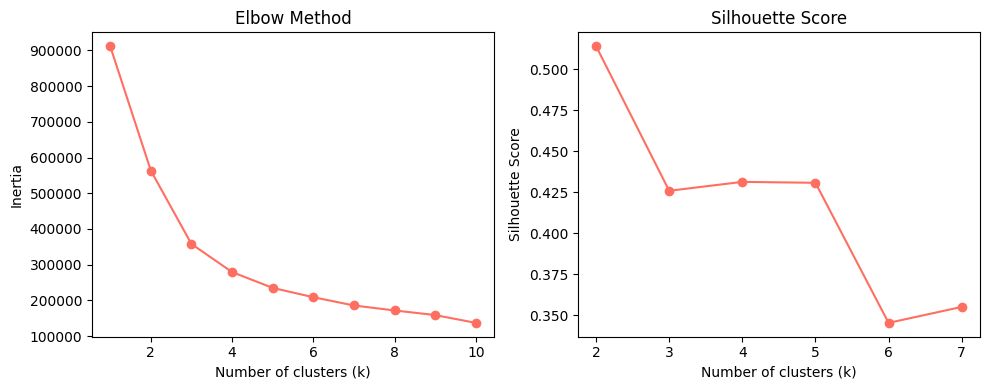

In [47]:
# Plot graphs to identifying optimal number of clusters for K-Means model
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(range(1, 11), inertia, marker='o', color='#FF6F61')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(range(2, 8), silhouette_scores, marker='o', color='#FF6F61')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.savefig('Elbow_Method_and_Silhouette_Scores.png', dpi=300, transparent='true')
plt.show()

In [48]:
# Download plots
files.download('Elbow_Method_and_Silhouette_Scores.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Elbow plot reveals a notable decline in inertia between **4** and **6** clusters, beyond which improvements in model fit begin to taper. Although silhouette analysis shows the highest score at **2** clusters (**0.514**), this binary segmentation is too coarse for meaningful customer profiling. We therefore select *k=4* as the optimal parameter - balancing cluster cohesion with segmentation granularity to support targeted weekday campaign strategies.

In [49]:
# Instantiate K-means model with optimal cluster count
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model to scaled RFM data and assign cluster labels
rfm_features['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [50]:
# Merge cluster labels with customer data
customer_data_df['CLUSTER'] = rfm_features['Cluster']


### 6.3 Model Evaluation & Results

In [51]:
# Add small random offset to FREQUENCY to prevent overplotting
rfm_features['FREQUENCY_jittered'] = rfm_features['FREQUENCY'] + np.random.uniform(-0.2, 0.2, size=len(rfm_features))

In [52]:
# Define function for pairwise scatterplots
def PlotScatterPlot(feature1, feature2):
  """
  Plot pairwise scatterplot for a variable by weekday.

  Parameters:
  - feature1: str, the name of the x variable to plot
  - feature2: str, the name of the y variable to plot
  """

  cluster_colors = {
      0: '#FFFF99',  # Light yellow
      1: '#FF6F61',  # Coral-orange
      2: '#F5E1D3',  # Beige-pink
      3: '#265C5C'   # Dark teal
      }

  colors = rfm_features['Cluster'].map(cluster_colors)

  ax = sns.scatterplot(
      data=rfm_features,
      x=feature1,
      y=feature2,
      hue='Cluster',
      palette=cluster_colors,
      s=1,
      alpha=0.7
      )
  ax.legend_.remove()

  plt.title('')
  plt.xlabel(feature1)
  plt.ylabel(feature2)


In [53]:
# Define function to plot legend for clusters
def PlotLegend():
  """
  Plot legend for clusters.
  """
  fig, ax = plt.subplots(figsize=(3, 2))
  cluster_colors = {
      0: '#FFFF99',  # Light yellow
      1: '#FF6F61',  # Coral-orange
      2: '#F5E1D3',  # Beige-pink
      3: '#265C5C'   # Dark teal
      }

  legend_elements = [
      Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
             markerfacecolor=color, markersize=10)
      for i, color in cluster_colors.items()
      ]

  ax.legend(handles=legend_elements, title='Customer Clusters', loc='center')
  ax.axis('off')


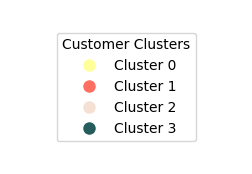

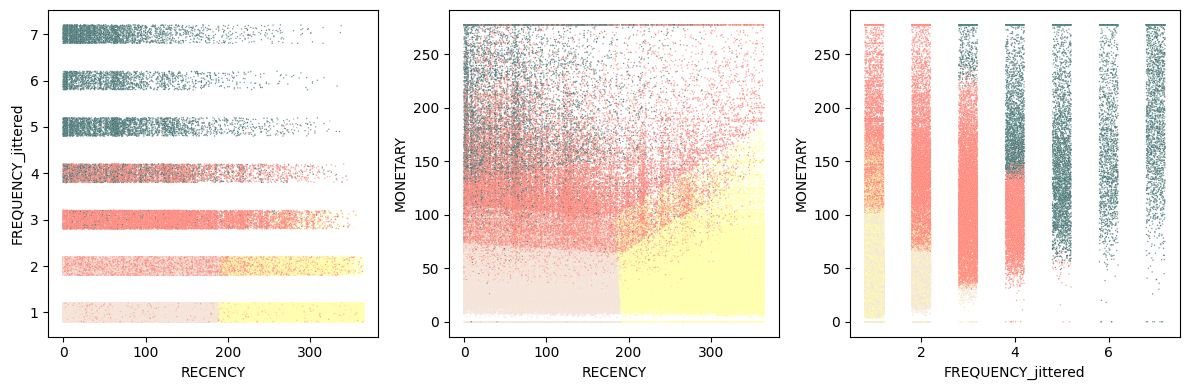

In [54]:
# Plot legend
PlotLegend()
plt.savefig('RFM_Cluster_Legend.png', dpi=300, transparent=True)
plt.show()

# Plot pairwise scatterplots
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
PlotScatterPlot('RECENCY', 'FREQUENCY_jittered')
plt.subplot(1,3,2)
PlotScatterPlot('RECENCY', 'MONETARY')
plt.subplot(1,3,3)
PlotScatterPlot('FREQUENCY_jittered', 'MONETARY')
plt.savefig('2D_RFM_Cluster_Plots.png', dpi=300, transparent=True)
plt.tight_layout()
plt.show()


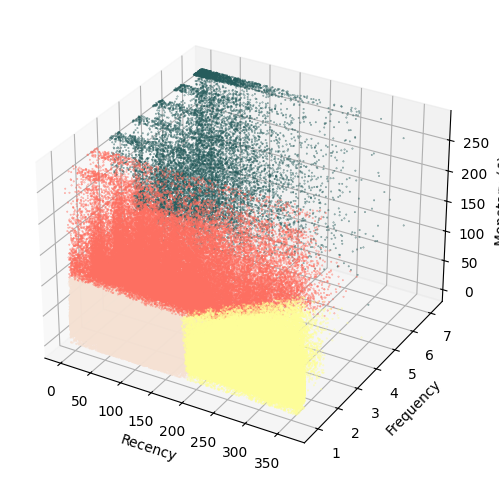

In [55]:
# Create 3D plot
cluster_colors = {
    0: '#FFFF99',  # Light yellow
    1: '#FF6F61',  # Coral-orange
    2: '#F5E1D3',  # Beige-pink
    3: '#265C5C'   # Dark teal
}
colors = rfm_features['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    rfm_features['RECENCY'],
    rfm_features['FREQUENCY_jittered'],
    rfm_features['MONETARY'],
    c=colors,
    s=0.1,
    alpha=0.8
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary (£)')
ax.set_title('')

plt.savefig('3D_RFM_Cluster_Plot.png', dpi=300, transparent=True)

plt.show()


In [56]:
# Generate interactive 3D scatter plot
plot_df = rfm_features.copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(str)  # Treat cluster as categorical

fig = px.scatter_3d(
    plot_df,
    x='RECENCY',
    y='FREQUENCY',
    z='MONETARY',
    color='Cluster',
    color_discrete_sequence=['#FFFF99', '#FF6F61', "#F5E1D3", "#265C5C"],
    title='Interactive 3D RFM Cluster Plot'
)

fig.update_traces(marker=dict(size=1, opacity=0.8))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

In [57]:
# Download plots
files.download('3D_RFM_Cluster_Plot.png')
files.download('RFM_Cluster_Legend.png')
files.download('2D_RFM_Cluster_Plots.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Cluster statistics
rfm_features.groupby('Cluster').describe()

RECENCY                                                            \
            count        mean        std    min    25%    50%    75%    max   
Cluster                                                                       
0        120979.0  285.488134  47.976070  183.0  248.0  285.0  324.0  365.0   
1         48224.0  111.078695  81.925709    0.0   46.0   95.0  159.0  365.0   
2        123615.0   91.101905  53.087617    0.0   51.0   89.0  136.0  197.0   
3         11087.0   69.308199  63.456639    0.0   19.0   56.0  100.0  344.0   

        FREQUENCY            ...  MONETARY           FREQUENCY_jittered  \
            count      mean  ...       75%       max              count   
Cluster                      ...                                          
0        120979.0  1.098645  ...   52.7000  180.0000           120979.0   
1         48224.0  2.377240  ...  134.7725  277.4232            48224.0   
2        123615.0  1.176572  ...   50.0000  107.8000           123615.0   
3         11087.0  5.383512  ...  253.7500  277.4232            11087.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
Cluster                                                                        
0        1.098530  0.329940  0.800011  0.909771  1.021234  1.131744  4.175455  
1        2.377965  0.858083  0.800055  1.898721  2.133714  3.012341  5.197615  
2        1.177304  0.402861  0.800005  0.921894  1.043543  1.164083  4.067560  
3        5.382865  1.260644  2.800912  4.155401  5.111799  6.836899  7.199836  

[4 rows x 32 columns]

In [59]:
# Cluster statistics customised
total_customers = customer_data_df['CLUSTER'].count()

cluster_summary = customer_data_df.groupby('CLUSTER').agg(
    Count=('CLUSTER', 'size'),
    Pct_Customers=('CLUSTER', lambda x: (x.count() / total_customers) * 100),
    Avg_Recency=('RECENCY', 'mean'),
    Avg_Frequency=('FREQUENCY', 'mean'),
    Avg_Monetary=('MONETARY', 'mean'),
    Median_Monetary=('MONETARY', 'median'),
    Max_Monetary=('MONETARY', 'max'),
    Std_Monetary=('MONETARY', 'std')
).reset_index()
cluster_summary

CLUSTER   Count  Pct_Customers  Avg_Recency  Avg_Frequency  Avg_Monetary  \
0        0  120979      39.808164   285.488134       1.098645     41.054440   
1        1   48224      15.868117   111.078695       2.377240    116.281228   
2        2  123615      40.675540    91.101905       1.176572     37.929432   
3        3   11087       3.648180    69.308199       7.639578    250.965911   

   Median_Monetary  Max_Monetary  Std_Monetary  
0            34.70        180.00     24.557022  
1           104.00       2350.48     62.198148  
2            33.80        107.80     19.666908  
3           183.25     304829.48   2899.697678

Based on the elbow method and silhouette analysis, a 4-cluster model was selected, yielding an inertia of **279,469.7** and a silhouette score of **0.4313**, indicating moderate separation between clusters.

The clusters segment the customers as follows:

> **Cluster 0: Dormant Low-Spenders**
>
> *Low recency, low frequency, low monetary value*
>
> Captures **39.8%** of customers who, on average, last booked **285** days ago with a potential booking spike during the winter months. These customers visited **once** in the last year and spent **£41.05**, suggesting low engagement and value.

> **Cluster 1: Dormant Big-Spenders**
>
> *Low recency, moderate frequency, high monetary value*
>
> Accounts for **15.9%** of customers who, on average, last booked **111** days ago, with **two** visits in the last year and a total spend of **£116.28** (**£49.06** per visit). Though recently dormant, this group represents high revenue potential if successfully reactivated.

> **Cluster 2: Early Explorers**
>
> *Moderate recency, low frequency, low monetary value*
>
> Includes **40.7%** of customers who on average last booked **91** days ago, visited just **once** in the last year, and spent **£37.92**. Despite limited spend and frequency, the relative recency suggests a potentially loyal segment - many of whom may be recently acquired and receptive to targeted weekday campaigns.

> **Cluster 3: Loyal Regulars**
>
> *High recency, high frequency, high monetary value*
>
> Represents just **3.6%** of the customer base but stands out for booking on average **70** days ago, visiting more than **7** times in the last year, and spending **£250.97** (**£32.89** per visit). These are the company's high-value loyalists who merit premium retention strategies.

### 6.4 Behavioural Analysis by Weekday

We analyse the weekday booking patterns for the four customer segments.

In [60]:
# Add customer segmentation to booking data
cleaned_bookingdata_df = cleaned_bookingdata_df.merge(
    customer_data_df[['CUSTOMERID', 'CLUSTER']],
    on='CUSTOMERID',
    how='left'
    )

In [69]:
# Aggregate data by visitday and cluster
weekday_cluster_data_df = cleaned_bookingdata_df.groupby(['VISITDAY', 'CLUSTER']).agg(
    BookingsCount=('VISITDAY', 'count')
).reset_index()

# Calculate % bookings for each cluster by weekday
weekday_cluster_data_df['Pct_Bookings'] = (
    weekday_cluster_data_df['BookingsCount'] /
    weekday_cluster_data_df.groupby('CLUSTER')['BookingsCount'].transform('sum')
).round(4) * 100

# Order by weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_cluster_data_df['VISITDAY'] = pd.Categorical(weekday_cluster_data_df['VISITDAY'], categories=weekday_order, ordered=True)
weekday_cluster_data_df = weekday_cluster_data_df.sort_values('VISITDAY').reset_index(drop=True)

In [70]:
# Define function to plot barchart by weekday
def PlotWeekdayClusterBarChart(cluster, colour, title):
  """
  Plot barchart for a variable by weekday.
  Parameters:
  - cluster: int, cluster number
  - colour: str, colour for barchart
  - title:, str, title for barchart
  """
  sns.barplot(
      x='VISITDAY',
      y='Pct_Bookings',
      data=weekday_cluster_data_df[weekday_cluster_data_df['CLUSTER'] == cluster],
      color=colour
      )
  plt.ylabel('Percentage (%)')
  plt.title(title)
  plt.xlabel('')


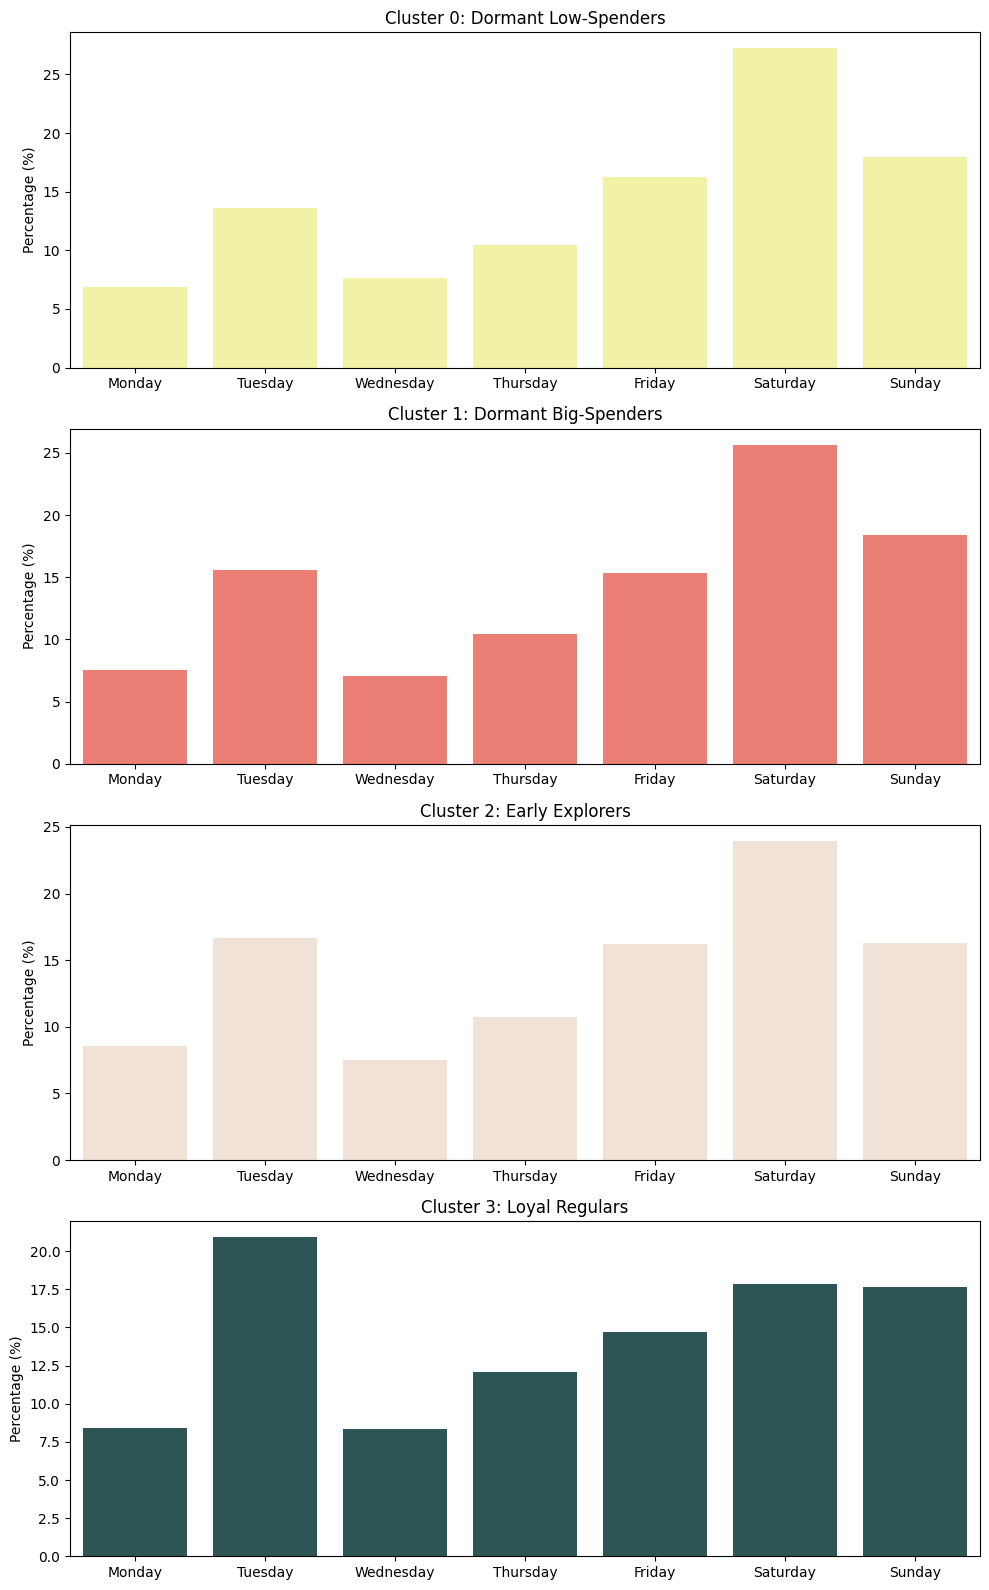

In [71]:
# Plot weekday booking patterns by cluster
plt.figure(figsize=(10, 16))
plt.subplot(4,1,1)
PlotWeekdayClusterBarChart(0, '#FFFF99', 'Cluster 0: Dormant Low-Spenders')
plt.subplot(4,1,2)
PlotWeekdayClusterBarChart(1, '#FF6F61', 'Cluster 1: Dormant Big-Spenders')
plt.subplot(4,1,3)
PlotWeekdayClusterBarChart(2, '#F5E1D3', 'Cluster 2: Early Explorers')
plt.subplot(4,1,4)
PlotWeekdayClusterBarChart(3, '#265C5C', 'Cluster 3: Loyal Regulars')
plt.tight_layout()
plt.savefig('weekday_bookings_by_cluster.png', dpi=300, transparent=True)
plt.show()

In [72]:
# Download plots
files.download('weekday_bookings_by_cluster.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We note that Cluster 3 'Loyal Regulars' are already responding well to Tuesday promotions, suggesting there's little incremental gain in targeting them further.

## 7 Recommendations

Based on the segmentation analysis and observed weekday booking behaviour, we recommend targeting Clusters 1 (Dormant Big-Spenders) and 2 (Early Explorers) for weekday promotions, while excluding Cluster 3 (Loyal Regulars). This strategy covers approximately **56.6%** of the customer base and focuses on segments with the highest potential for incremental weekday growth.

We recommend the following next steps:

> **1. Strategic Targeting**
* Focus on clusters 1 and 2.
* Exclude customers who already regularly book on Mondays, Wednesdays, or Thursdays.

> **2. Segment Profiling**
* Booking channel usage (e.g., web vs. phone/in-person)
* Reservation types or party size
* Weekday vs. weekend preferences
* Seasonal and promotional responsiveness
* Regional/site-level booking patterns

> **3. Campaign Design**
* Align offer design with customer preferences and past booking behaviour.
* Tailor weekday incentives by cluster to reflect differing motivations (eg.reactivation vs. frequency building).
* Run an initial pilot campaign with A/B testing to validate messaging and offer strategy.

> **4. Toward Predictive Targeting**
* Develop a propensity model to score customers based on likelihood to respond to weekday campaigns.
* Use this model to enable more scalable, automated campaign targeting and future CRM optimisation.



David P Briggs
10 July 2025
https://github.com/dpb24

In [ ]:
# Filter target clusters and save to CSV
target_segments_df = customer_data_df[
    customer_data_df['CLUSTER'].isin([1, 2])
]
target_segments_df.to_csv('Campaign_Target_Customers.csv', index=False)

In [ ]:
# Download CSV
files.download('Campaign_Target_Customers.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>